In [21]:
import os
import pandas
import tarfile
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers[0].setFormatter(logging.Formatter('%(asctime)s: %(message)s'))

locations = {
    'gfs': '/l/cnets/datasets/Telecom_BDC_2015',
    'diskstation': '/media/diskstation/Datasets/Telecom Big Data Challenge 2015',
    'data': os.path.expanduser('~/data/tbdc15'),
    'hdd': '/media/giovanni/Multimedia/Datasets/Telecom Big Data Challenge 2015',
    'repo': os.path.expanduser('~/repos/tbdc15')
}


def getpaths(city, loc='gfs', boxesloc=None, storeloc=None):
    root = locations[loc]
    city_codes = {'RO': 'RM'}
    code = city[:2].upper()
    if code in city_codes:
        code = city_codes[code]
    paths = {
        'trips': '{root}/infoblu/{city}.tar.gz'.format(root=root, city=city),
        'accidents': '{root}/unipol/BDC2015_UnipolsaiClaims2014_{city}.csv'.format(root=root, city=code),
        'boxes': '{root}/city_boxes.csv'.format(root=root if boxesloc is None else locations[boxesloc]),
        'store': '{root}/trip_accidents_store.hdf'.format(root=root if storeloc is None else locations[storeloc])
    }
    return paths


def getbox(path, city):
    city_code = city[0].lower()
    df_box = pandas.read_csv(path, index_col='city')
    df_box.ix[city_code]
    box = df_box.ix[city_code].to_dict()
    return box


def read_trips(path, box, scale=1000.0, break_at=None):
    index_columns = ['i', 'j', 'weekday', 'hour']
    trips = pandas.DataFrame(columns=index_columns + ['trips', 'trips_start']).set_index(index_columns)

    # set break_at to an integer and it will stop exactly after that number of iterations
    i = 0

    with tarfile.open(path, mode='r:gz') as tf:
        # open tar file in random access mode with on-the-fly gzip decompression
        for member in tf:
            if break_at is not None and i == break_at:
                break
            i += 1

            # read contents of TAR archive. Each file in the archive contains 
            # the data of a different day.
            logger.info(member.name)
            f = tf.extractfile(member)

            # do not use the "type" and "speed" columns, since we don't need them. This saves memory.
            df = pandas.read_csv(f, 
                                 names=['trip', 'timestamp', 'lat', 'lon', 'type', 'speed'],
                                 usecols=['trip', 'timestamp', 'lat', 'lon'],
                                 sep=';', 
                                 parse_dates=['timestamp'])

            # compute the cell, weekday, and hour
            df['i'] = ((df['lat'] - box['lat_min']) * scale).round()
            df['j'] = ((df['lon'] - box['lon_min']) * scale).round()
            df['weekday'] = df['timestamp'].map(pandas.Timestamp.weekday)
            df['hour'] = df['timestamp'].map(lambda k: k.hour)

            # count how many trips in each cell, weekday, hour and append. 
            # Note that the first group-by returns a series object, 
            # and we wrap this into a DataFrame.        
            s1 = df.filter(index_columns).groupby(index_columns).apply(len)

            # do the same but only considering the first frame of each trip.
            df_ff = df.groupby('trip', as_index=False).head(1)
            s2 = df_ff.filter(index_columns).groupby(index_columns).apply(len)

            df = pandas.DataFrame({'trips': s1, 'trips_start': s2})
            
            trips = trips.append(df)

    return trips


def read_accidents(path, box, scale=1000.0):
    index_columns = ['i', 'j', 'weekday', 'hour']    
    df = pandas.read_csv(path)
    df.rename(columns={'day_type': 'weekday', 'time_range': 'hour'}, inplace=True)
    df['i'] = ((df['latitude'] - box['lat_min']) * scale).round()
    df['j'] = ((df['longitude'] - box['lon_min']) * scale).round()
    s = df.groupby(index_columns).apply(len)
    accidents = pandas.DataFrame({'accidents': s})
    return accidents


def make_city_frame(city, 
                    loc='frosty', 
                    boxesloc='frosty',
                    storeloc='frosty',
                    scale=1000.0, 
                    break_at=None):
    """
    Reads data of trips and accidents and store data frame into HDF format
    """
    paths = getpaths(city, loc=location, boxesloc=boxesloc, storeloc=storeloc)
    box = getbox(paths['boxes'], city)
    logger.info("Reading trips...")
    trips = read_trips(paths['trips'], box, scale=scale, break_at=break_at)
    logger.info("Reading accidents...")
    accidents = read_accidents(paths['accidents'], box, scale=scale)
    logger.info("Storing data...")
    joined_df = trips.join(accidents).fillna(0).reset_index()
    joined_df.to_hdf(paths['store'], city)
    logger.info("Data saved to HDF.")

# Create dataset

## Select city 

In [57]:
cities = ['bari', 'milano', 'napoli', 'palermo', 'roma', 'torino', 'venezia']
location = 'gfs'
boxes_location = 'data'
store_location = 'data'
scale = 1000.0

## Read data

In [27]:
rm -f /u/gciampag/data/tbdc15/trip_accidents_store.hdf

rm: cannot remove `/u/gciampag/data/tbdc15/trip_accidents_store.hdf': No such file or directory


In [30]:
ll -h /u/gciampag/data/tbdc15/

total 4.0K
-rw-r--r-- 1 gciampag 518 Nov  2 00:09 city_boxes.csv


In [58]:
cities.remove('palermo')

In [ ]:
for city in cities:
    logging.info("City: {}".format(city))
    make_city_frame(city, 
                    loc=location, 
                    scale=scale, 
                    boxesloc=boxes_location,
                    storeloc=store_location, 
                    break_at=None)

2015-11-02 13:41:45,861: City: bari
2015-11-02 13:41:45,868: Reading trips...
2015-11-02 13:41:45,875: output_20150301_BARI.txt
2015-11-02 13:43:28,879: output_20150302_BARI.txt
2015-11-02 13:45:36,050: output_20150303_BARI.txt
2015-11-02 13:47:46,937: output_20150304_BARI.txt
2015-11-02 13:50:01,627: output_20150305_BARI.txt
2015-11-02 13:52:18,615: output_20150306_BARI.txt
2015-11-02 13:54:35,503: output_20150307_BARI.txt
2015-11-02 13:56:47,966: output_20150308_BARI.txt
2015-11-02 13:58:33,373: output_20150309_BARI.txt
2015-11-02 14:00:46,119: output_20150310_BARI.txt
2015-11-02 14:02:49,017: output_20150311_BARI.txt
2015-11-02 14:04:36,042: output_20150312_BARI.txt
2015-11-02 14:06:19,618: output_20150313_BARI.txt
2015-11-02 14:08:22,741: output_20150314_BARI.txt
2015-11-02 14:10:39,439: output_20150315_BARI.txt
2015-11-02 14:12:27,206: output_20150316_BARI.txt
2015-11-02 14:14:54,716: output_20150317_BARI.txt
2015-11-02 14:17:07,399: output_20150318_BARI.txt
2015-11-02 14:19:30,31

# Plot the data

In [40]:
%matplotlib inline
import numpy
from pylab import *

## Read the data from HDF 

In [60]:
city = 'roma'

In [61]:
paths = getpaths(city, 
                 loc=location, 
                 boxesloc=boxes_location,
                 storeloc=store_location, )
df = pandas.read_hdf(paths['store'], city)
# df = df.query('(weekday < 5) & ((hour >= 20) | (hour <= 6))')
df = df.groupby(['i', 'j']).sum().filter(['trips', 'trips_start', 'accidents'])
#df = df.query('accidents > 0')

## Scatter plot of trips vs trip starts 

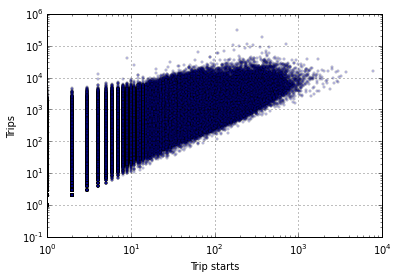

In [62]:
df.plot(x='trips_start', y='trips', kind='scatter', alpha=.2, marker='.')
xscale('log')
yscale('log')
xlim(1, 1e4)
xlabel('Trip starts')
ylabel('Trips')
savefig("trips_trips_starts_scatter_{}.pdf".format(city))

## Scatter plot of trips vs accidents in each cell with average trend

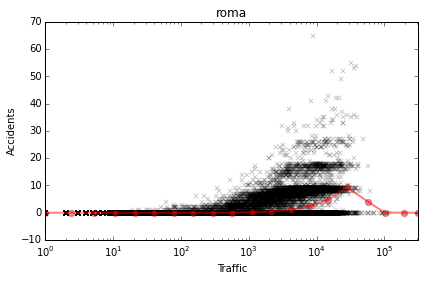

In [63]:
# scatter plot
df.plot(x='trips', y='accidents', kind='scatter', marker='x', alpha=.2, color='k')

# trend line
bins = numpy.logspace(numpy.log10(df['trips'].min()), numpy.log10(df['trips'].max()), 20)
df.groupby(numpy.digitize(df['trips'], bins=bins)).mean().plot(x='trips', y='accidents',
                                                               color='r', linestyle='solid',
                                                               marker='o',
                                                               ax=gca(), alpha=.5, linewidth=2)
grid('off')
title(city)
xlabel('Traffic')
ylabel('Accidents')
#ylim(0, 30)
xscale('log')
#yscale('log')
tight_layout()
savefig('trips_accidents_scatter_{}.pdf'.format(city))
show()

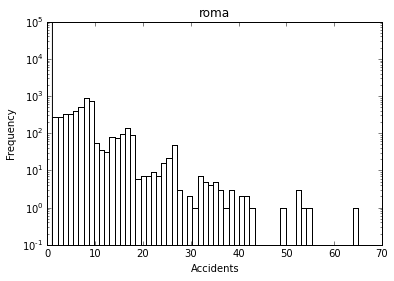

In [64]:
hist(df['accidents'], log=True, bins=60, color='white')
ylim(.1, 1e5)
xlabel('Accidents')
ylabel('Frequency')
title(city)
savefig('accidents_histogram_{}.pdf'.format(city))